## Spark 
---
#### Elo notes


### Spark - Local Cluster
#### Data processing 

Start a tmux session which will host your master node:

```
# bash
tmux new -s elomaster
```

Spark master to listen on local IP. 
The Master class in ***org.apache.spark.deploy.master*** accepts the following 
parameters: 

```
# bash
${SPARK_HOME}/bin/spark-class org.apache.spark.deploy.master.Master \
-h 127.0.0.1 \
-p 7077 \
--webui-port 8080
```

Creating two workers

```bash
${SPARK_HOME}/bin/spark-class org.apache.spark.deploy.worker.Worker \
-c 1 \
-m 1G \
spark://127.0.0.1:7077
```

Attaching Jupyter notebook to the master

```bash
IPYTHON_OPTS="notebook"  ${SPARK_HOME}/bin/pyspark \
--master spark://127.0.0.1:7077 \
--executor-memory 1G \
--driver-memory 1G
```


In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
sc

In [3]:
link = 's3n://mortar-example-data/airline-data'

In [4]:
rddairline = sc.textFile(link)

In [5]:
rddairline.take(2)

[u'"YEAR","MONTH","UNIQUE_CARRIER","ORIGIN_AIRPORT_ID","DEST_AIRPORT_ID","DEP_DELAY","DEP_DELAY_NEW","ARR_DELAY","ARR_DELAY_NEW","CANCELLED",',
 u'2012,4,"AA",12478,12892,-4.00,0.00,-21.00,0.00,0.00,']

In [6]:
rddairline.count()

5113194

In [7]:
rddchunk = sc.parallelize(rddairline.take(100))

In [8]:
rddchunk.take(3)

[u'"YEAR","MONTH","UNIQUE_CARRIER","ORIGIN_AIRPORT_ID","DEST_AIRPORT_ID","DEP_DELAY","DEP_DELAY_NEW","ARR_DELAY","ARR_DELAY_NEW","CANCELLED",',
 u'2012,4,"AA",12478,12892,-4.00,0.00,-21.00,0.00,0.00,',
 u'2012,4,"AA",12478,12892,-7.00,0.00,-65.00,0.00,0.00,']

In [9]:
# Preprocessing : RDDairline

rddairl = rddairline.map(lambda x: x.replace('\'', '').replace('\"', '').strip(','))

In [10]:
rddairl.take(3)

[u'YEAR,MONTH,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_DELAY,DEP_DELAY_NEW,ARR_DELAY,ARR_DELAY_NEW,CANCELLED',
 u'2012,4,AA,12478,12892,-4.00,0.00,-21.00,0.00,0.00',
 u'2012,4,AA,12478,12892,-7.00,0.00,-65.00,0.00,0.00']

In [11]:
colnames = rddairl.first()
features = colnames.split(',')

In [12]:
features

[u'YEAR',
 u'MONTH',
 u'UNIQUE_CARRIER',
 u'ORIGIN_AIRPORT_ID',
 u'DEST_AIRPORT_ID',
 u'DEP_DELAY',
 u'DEP_DELAY_NEW',
 u'ARR_DELAY',
 u'ARR_DELAY_NEW',
 u'CANCELLED']

In [13]:
features[5]

u'DEP_DELAY'

In [14]:
rddcontent = rddairl.filter(lambda x: x != colnames)

In [15]:
rddcontent.take(3)

[u'2012,4,AA,12478,12892,-4.00,0.00,-21.00,0.00,0.00',
 u'2012,4,AA,12478,12892,-7.00,0.00,-65.00,0.00,0.00',
 u'2012,4,AA,12478,12892,-6.00,0.00,-63.00,0.00,0.00']

In [16]:
rddcontent100 = sc.parallelize(rddcontent.take(100))

In [17]:
def dfeat(x):
    rowl = x.split(',')
    d = dict(zip(features, rowl))
    keys = ['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','DEP_DELAY', 'ARR_DELAY']
    dictf = {k: (d[k] if d[k] else 0.) for k in keys}
    
    dictf['DEP_DELAY'] = float(rowl[5]) if len(rowl[5]) >0 else 0
    dictf['ARR_DELAY'] = float(rowl[7]) if len(rowl[7]) >0 else 0
    
    # Actual arrival delay
    
    dictf['ARR_DELAY'] -= dictf['DEP_DELAY']
    
    # if cancelled then add 5hrs to 'DEP_DELAY' 
    if float(rowl[-1]) != 0:
        dictf['DEP_DELAY'] += 5*60
    
    return dictf    
    

In [18]:
rddcontent100.map(lambda x: dfeat(x)).take(2)

[{'ARR_DELAY': -17.0,
  'DEP_DELAY': -4.0,
  'DEST_AIRPORT_ID': u'12892',
  'ORIGIN_AIRPORT_ID': u'12478'},
 {'ARR_DELAY': -58.0,
  'DEP_DELAY': -7.0,
  'DEST_AIRPORT_ID': u'12892',
  'ORIGIN_AIRPORT_ID': u'12478'}]

In [19]:
airline_rows = (
    rddcontent
    .map(lambda x: dfeat(x))
    .setName('airline_mapped')
    .persist()
)

In [20]:
departure_delay = (
    airline_rows
    .map(lambda x: (x['ORIGIN_AIRPORT_ID'], x['DEP_DELAY']))
    .setName('departure_delays')
    .persist()
)

In [21]:
arrival_delay = (
    airline_rows
    .map(lambda x: (x['DEST_AIRPORT_ID'], x['ARR_DELAY']))
    .persist()
)

In [22]:
def mean_delay(rdd):
    return (
        rdd.groupByKey()
        .mapValues(lambda x: sum(x) / float(len(x)))
    )

In [23]:
mean_depdelay = mean_delay(departure_delay).setName('mean_depdelay').persist()
mean_arrdelay = mean_delay(arrival_delay).setName('mean_arrdelay').persist()

In [24]:
mean_depdelay.take(3)

[(u'10141', 3.0860655737704916),
 (u'13851', 7.777691453940067),
 (u'14952', 6.6351271437019514)]

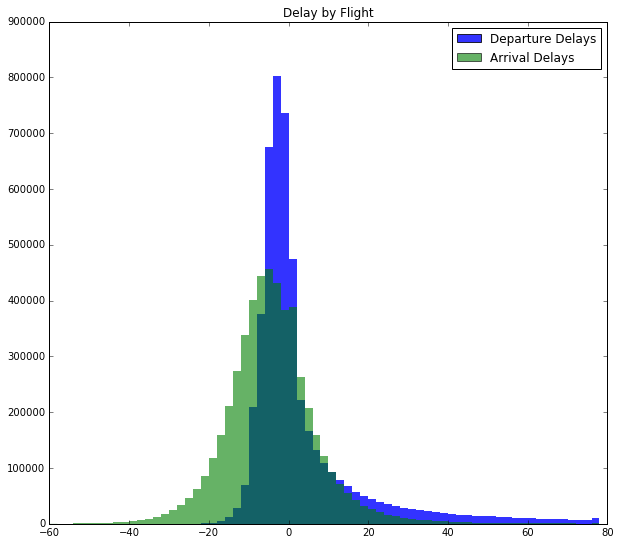

In [25]:
plt.figure(figsize=(10, 9));
bins = np.arange(-60, 80, 2)

plt.hist(departure_delay.values().collect(),
        bins=bins, ec='none', label='Departure Delays', alpha=0.8);
plt.hist(arrival_delay.values().collect(),
        bins=bins, ec='none', label='Arrival Delays', alpha=0.6);

plt.title('Delay by Flight');
plt.legend();


In [26]:
# Lowest average delay
mean_depdelay.sortBy(lambda(x, y): y ).take(5)

[(u'13127', -2.950089126559715),
 (u'14113', -2.813027744270205),
 (u'11336', -1.7261904761904763),
 (u'10739', -1.7254901960784315),
 (u'10466', -1.625)]

In [27]:
# Higuest average delay
mean_depdelay.sortBy(lambda(x, y): -1*y).take(5)

[(u'10930', 60.73560517038778),
 (u'13388', 60.03344481605351),
 (u'13964', 52.38934426229508),
 (u'13424', 49.313011828935394),
 (u'10157', 45.66734211415063)]

In [28]:
# Lowest average delay
mean_arrdelay.sortBy(lambda(x, y): y).take(10)

[(u'11415', -12.653968253968253),
 (u'12389', -10.4),
 (u'11537', -9.228426395939087),
 (u'13541', -8.772727272727273),
 (u'10581', -8.133451957295375),
 (u'11252', -8.116187989556137),
 (u'12888', -8.018518518518519),
 (u'12007', -7.959183673469388),
 (u'12094', -7.332170880557977),
 (u'10466', -7.1875)]

In [30]:
# Highest average delay
mean_arrdelay.sortBy(lambda(x, y): -1*y).take(10)


[(u'14955', 13.0),
 (u'14794', 3.7736625514403292),
 (u'12177', 3.576540755467197),
 (u'14802', 2.8),
 (u'10918', 2.4816176470588234),
 (u'14254', 1.7567185289957568),
 (u'15295', 1.6835443037974684),
 (u'12402', 1.4020996500583236),
 (u'10551', 0.8428745432399513),
 (u'15356', 0.8)]

---
#### RDD (Resilient Distributed Dataset)
- Resilient -- if the data in memory is lost, it can be recreated

- Distributed -- stored in memory across the cluster

- Dataset -- initial data can come from a file or created programmatically


•	RDDs are the fundamental unit of data in Spark

•	RDD is a read-only, partitioned collection of records

•	Most of Spark programming is performing operations on RDDs
 
#### Two types of RDD operations

◦	__Actions__ - return values
 
 ▪	count
 
 ▪	take(n)
 
◦	__Transformations__ - define new RDDs based on the current one

▪	filter
		
▪	map
		
▪	reduce
